In [1]:
#Import needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.decomposition

import phate as ph

np.random.seed(1)

In [2]:
class KernelPCA_RBF:
    def __init__(self, n_components=2, sigma=1.0):
        self.n_components = n_components
        self.sigma = sigma
        self.X = None
        self.kernel_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def rbf_kernel(self, x1, x2):
        return np.exp(-(1 / (2 * self.sigma**2)) * np.linalg.norm(x1 - x2, axis=0)**2)
    
    def compute_kernel_matrix(self, X):
        n = X.shape[0]
        #K = np.zeros((n, n))
        # for i in range(n):
        #     for j in range(n):
        #         K[i, j] = self.rbf_kernel(X[i], X[j])
        # return K
        col = X.T.reshape((X.shape[1], -1, 1))
        row = X.T.reshape((X.shape[1], 1, -1))

        K = self.rbf_kernel(col, row)
        return K

    def center_kernel_matrix(self, Kernel):
        n = Kernel.shape[0]
        ones_mat = np.ones((n,n))/n
        K_tilda = Kernel - np.dot(ones_mat,Kernel) - np.dot(Kernel,ones_mat) + np.dot(np.dot(ones_mat,Kernel),ones_mat)
        return K_tilda

    def fit(self, X):
        self.X = X
        self.kernel_matrix = self.compute_kernel_matrix(X)
        self.kernel_matrix = self.center_kernel_matrix(self.kernel_matrix)
        eigenvalues, eigenvectors = np.linalg.eigh(self.kernel_matrix)
        #Sort eigenvectors and eigenvalues in descending order
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        self.eigenvectors = eigenvectors[:, indices]
    
    def transform(self):
        return self.eigenvectors[:, :self.n_components]

    def fit_transform(self, X):
        self.fit(X)
        return self.transform()

# Class for doing the standard version of PCA
class KernelPCA_Linear: #same as doing normal PCA
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.X = None
        self.kernel_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def linear_kernel(self, x1, x2):
        return np.dot(x1,x2)
    
    def compute_kernel_matrix(self, X):
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.linear_kernel(X[i], X[j])
        return K
    
    def center_kernel_matrix(self, Kernel):
        n = Kernel.shape[0]
        ones_mat = np.ones((n,n))/n
        K_tilda = Kernel - np.dot(ones_mat,Kernel) - np.dot(Kernel,ones_mat) + np.dot(np.dot(ones_mat,Kernel),ones_mat)
        return K_tilda

    def fit(self, X):
        self.X = X
        self.kernel_matrix = self.compute_kernel_matrix(X)
        self.kernel_matrix = self.center_kernel_matrix(self.kernel_matrix)
        eigenvalues, eigenvectors = np.linalg.eigh(self.kernel_matrix)
        #Sort eigenvectors and eigenvalues in descending order
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        self.eigenvectors = eigenvectors[:, indices]
    
    def transform(self):
        return self.eigenvectors[:, :self.n_components]
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform()


In [3]:
#Load the dataset

dataset = pd.read_csv('data/processed_bert.csv')

dataset.head()


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,target,text
0,-0.822546,-0.472057,-0.579868,0.601334,0.001131,-0.033307,0.621883,0.219169,-0.297440,-0.999933,...,0.746353,0.789280,0.454223,0.652186,0.384898,-0.173033,-0.653783,0.722890,1,Our Deeds are the Reason of this #earthquake M...
1,-0.932106,-0.444832,-0.946184,0.783482,0.649199,-0.417868,0.810984,0.553593,-0.841144,-0.999991,...,0.972591,0.666550,-0.809021,0.077952,0.690775,-0.809868,-0.695485,0.752990,1,Forest fire near La Ronge Sask. Canada
2,-0.786213,-0.454594,-0.989117,0.766382,0.825029,-0.260707,0.601579,0.324533,-0.961853,-0.999995,...,0.992954,0.505823,-0.130431,-0.429334,0.774262,-0.879583,-0.601859,0.773692,1,All residents asked to 'shelter in place' are ...
3,-0.929848,-0.641187,-0.984187,0.838084,0.698074,-0.439465,0.848216,0.544355,-0.940431,-0.999996,...,0.995336,0.807030,-0.736760,-0.092651,0.772516,-0.862276,-0.756446,0.812085,1,"13,000 people receive #wildfires evacuation or..."
4,-0.782167,-0.475203,-0.785371,0.579609,0.718675,-0.169704,0.333027,0.279532,-0.594330,-0.999871,...,0.968012,0.792530,0.080506,0.567232,0.400888,-0.405238,-0.665966,0.872382,1,Just got sent this photo from Ruby #Alaska as ...


In [4]:

#set up x and y 

y = np.asarray(dataset[['target']])
x = np.asarray(dataset)[:,:-2]

#split into the training and test sets

(7613, 2)


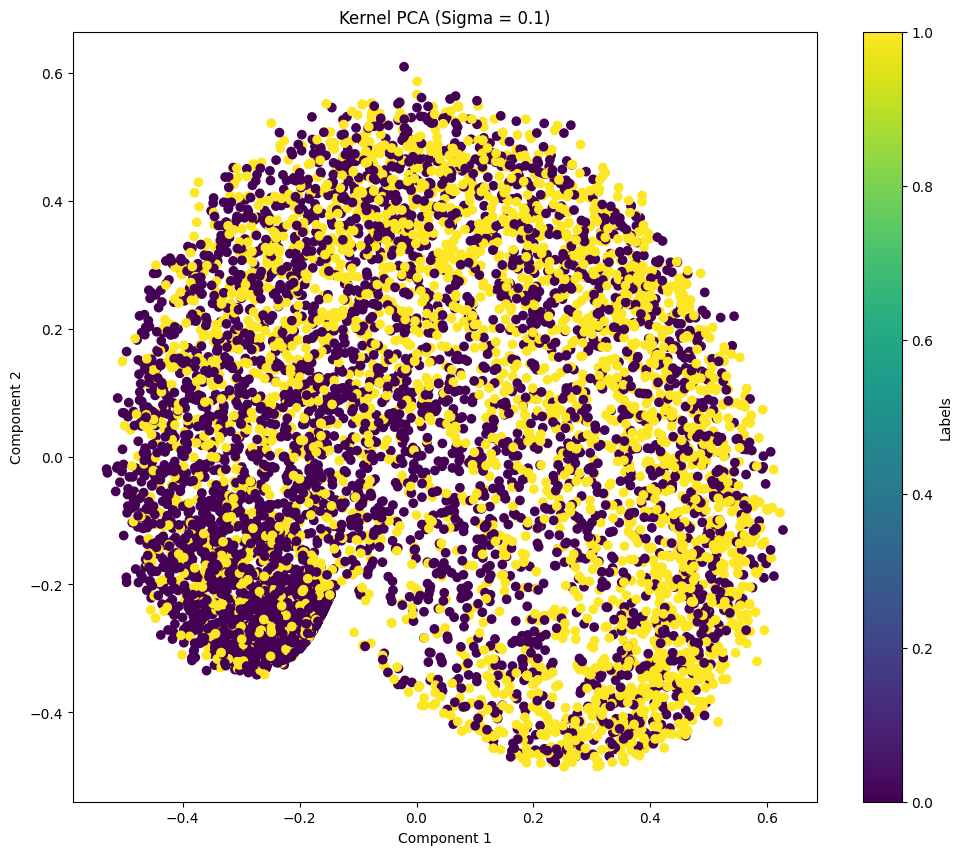

In [5]:
#Lets see how it looks from PCA prespective

sigma = 0.1


x_pca = sk.decomposition.KernelPCA(n_components=2,kernel='rbf',gamma=sigma).fit_transform(x)

print(x_pca.shape)
#Plot the results as a single figure
plt.figure(figsize=(12, 10))

# Plot Kernel PCA with sigma = 0.1
plt.subplot(1,1 , 1)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y)
plt.title(f"Kernel PCA (Sigma = {sigma})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

plt.savefig(f'KPCA_visualization_simga.png',dpi=200)


Calculating PHATE...
  Running PHATE on 7613 observations and 768 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.90 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.97 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 4.92 seconds.
  Calculating landmark operator...
    Calculating SVD...


/home/eric/Desktop/repos/HybridRocket/venv/lib64/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 207 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/eric/Desktop/repos/HybridRocket/venv/lib64/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 0.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.66 seconds.
  Calculated landmark operator in 2.69 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 1.23 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.57 seconds.
Calculated PHATE in 12.89 seconds.


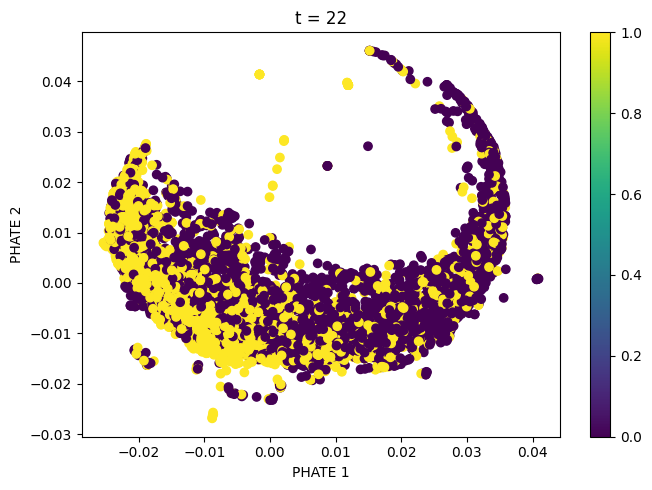

In [10]:
#visualize using phate instead


phate_operator = ph.PHATE(n_jobs=12,gamma=0.1) #allow it to run on twelve processes
phate_embedding = phate_operator.fit_transform(x)

embedding1 = phate_embedding

#Get t from VNE
t_vne = phate_operator.optimal_t


Phate_plot = plt.figure(figsize=(7, 5))

plt.scatter(embedding1[:, 0], embedding1[:, 1], c=y, cmap='viridis')
plt.title(f"t = {t_vne}")
plt.colorbar()
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.tight_layout()
plt.savefig('Phate_Visualization.png',dpi=200)

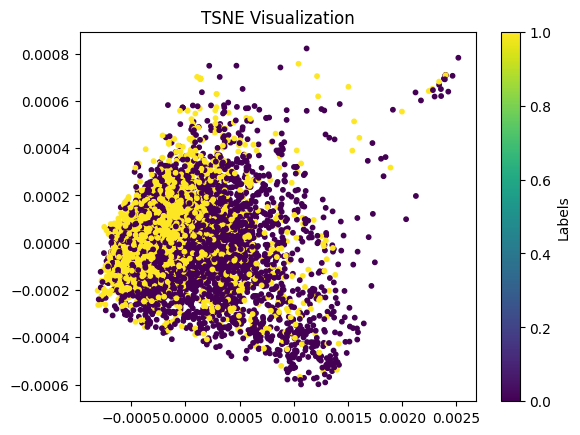

In [16]:
#Trying it out as TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=1,n_jobs=16,n_iter=2000,learning_rate=0.01)
tsne_embedding = tsne.fit_transform(x)

plt.scatter(tsne_embedding[:,0],tsne_embedding[:,1], c = y, cmap='viridis',s=10)
plt.title('TSNE Visualization')
plt.colorbar(label='Labels')
plt.savefig('TSNE_Visualization.png',dpi=200)



2024-04-10 15:43:26.529960: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 15:43:26.532786: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 15:43:26.573203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 15:43:27.285020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


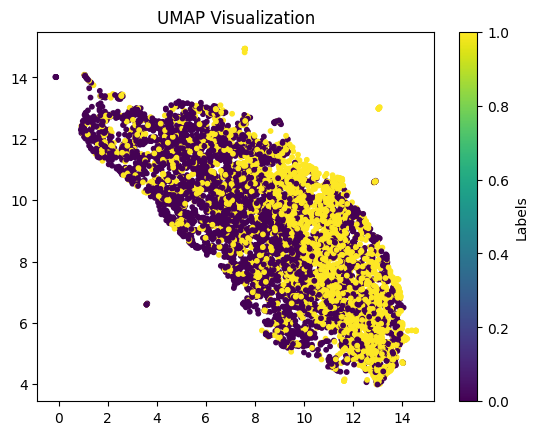

In [8]:
import umap.umap_ as umap

y = np.asarray(dataset[['target']])
x = np.asarray(dataset)[:,:-2]


reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(x)

plt.scatter(umap_embedding[:,0],umap_embedding[:,1], c = y, cmap='viridis',s=10)
plt.title('UMAP Visualization')
plt.colorbar(label='Labels')
plt.savefig('UMap_Visualization.png',dpi=200)



In [9]:
#Try it again as TSNE method